In [1]:
import os
import pickle

import numpy as np
import pandas as pd
import torch

import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, random_split
from torch.nn.functional import one_hot

from data_loaders.pulja_data_loader import PuljaDataLoader
from models._20220615_00 import UserModel
from models.utils import collate_fn

if torch.cuda.is_available():
    from torch.cuda import FloatTensor, LongTensor
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
else:
    from torch import FloatTensor, LongTensor

In [2]:
ckpt_path = "ckpts"
if not os.path.isdir(ckpt_path):
    os.mkdir(ckpt_path)

batch_size = 256
num_epochs = 100
train_ratio = 0.9

seq_len = 100

dim_v = 20

dataset = PuljaDataLoader(seq_len)

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

model = UserModel(dataset.num_c1, dataset.num_c2, dataset.num_d, dim_v).to(device)

train_size = int(len(dataset) * train_ratio)
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(
    dataset, [train_size, test_size]
)

if os.path.exists(os.path.join(dataset.dataset_dir, "indices.pkl")):
    with open(os.path.join(dataset.dataset_dir, "indices.pkl"), "rb") as f:
        indices = pickle.load(f)
    train_dataset.indices = indices[0]
    test_dataset.indices = indices[1]
else:
    with open(os.path.join(dataset.dataset_dir, "indices.pkl"), "wb") as f:
        pickle.dump((train_dataset.indices, test_dataset.indices), f)


In [3]:
tb_unit1 = pd.read_csv(
    os.path.join("tables", "tb_unit1.csv")
)
tb_unit2 = pd.read_csv(
    os.path.join("tables", "tb_unit2.csv")
)

c22c1 = {}
for _, row in tb_unit2.iterrows():
    c2 = row["name"]
    c1 = tb_unit1[tb_unit1["unit1Seq"] == row["unit1Seq"]]["name"].values[0]
    
    c22c1[c2] = c1

c22c1_indices = [dataset.c12idx[c22c1[c2]] for c2 in [dataset.c2_list[i] for i in range(dataset.num_c2)]]

In [4]:
for d in [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]:
    print(np.mean(
        (dataset.df[dataset.df["difficulty_cd"] == d]["isCorrect"] == "Y")
    ))

0.7921283637933516
0.7606350303309529
0.6993804186706195
0.6255284784570804
0.5165942658557776
0.4108843537414966
0.09523809523809523


In [5]:
for d in [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]:
    print(np.mean(
        (dataset.df[dataset.df["difficulty_cd"] == d]["isCorrect"] == "Y") & \
        (dataset.df[dataset.df["difficulty_cd"] == d]["duration"] <= dataset.difficulty2duration[d])
    ))

0.6596872451671704
0.6323619749673655
0.5648320945261429
0.4726141275948886
0.39374456993918333
0.3564625850340136
0.09523809523809523


In [6]:
difficulty2duration = {
    1.0: 1.5,
    2.0: 2.0,
    3.0: 2.5,
    4.0: 2.5,
    5.0: 3.0,
    6.0: 5.0,
    7.0: 7.0,
}
for d in [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]:
    print(np.mean(
        (dataset.df[dataset.df["difficulty_cd"] == d]["isCorrect"] == "Y") & \
        (dataset.df[dataset.df["difficulty_cd"] == d]["duration"] <= difficulty2duration[d] * 60)
    ))

0.6596872451671704
0.6323619749673655
0.5648320945261429
0.4726141275948886
0.39374456993918333
0.3564625850340136
0.09523809523809523


In [7]:
model.load_state_dict(
    torch.load(
        os.path.join(
            os.path.join(
                ckpt_path, "_20220615_00"
            ),
            "model_fin.ckpt"
        ),
        map_location=device
    )
)
model.eval()

UserModel(
  (D): Embedding(7, 1)
  (gru): GRU(40, 20, batch_first=True)
  (linear_1): Sequential(
    (0): Linear(in_features=20, out_features=20, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=20, out_features=1, bias=True)
    (4): Dropout(p=0.5, inplace=False)
  )
  (linear_2): Sequential(
    (0): Linear(in_features=80, out_features=20, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=20, out_features=2, bias=True)
    (4): Dropout(p=0.5, inplace=False)
  )
)

In [8]:
####################################################################

# c1_seq = np.array([[c22c1_indices[0]] * 7])
# c2_seq = np.array([[0] * 7])
# d_seq = np.array([[1, 2, 3, 4, 5, 6, 7]]) - 1
# r_seq = np.array([[1, 1, 1, 1, 1, 1, 1]])

# c1_seq = np.array([[c22c1_indices[0]] * 7])
# c2_seq = np.array([[0] * 7])
# d_seq = np.array([[1, 2, 3, 4, 5, 6, 7]]) - 1
# r_seq = np.array([[1, 1, 1, 1, 1, 1, 0]])

# c1_seq = np.array([[c22c1_indices[0]] * 7])
# c2_seq = np.array([[0] * 7])
# d_seq = np.array([[1, 2, 3, 4, 5, 6, 7]]) - 1
# r_seq = np.array([[1, 1, 1, 1, 1, 0, 0]])

# c1_seq = np.array([[c22c1_indices[0]] * 7])
# c2_seq = np.array([[0] * 7])
# d_seq = np.array([[1, 2, 3, 4, 5, 6, 7]]) - 1
# r_seq = np.array([[1, 1, 1, 1, 0, 0, 0]])

# c1_seq = np.array([[c22c1_indices[0]] * 7])
# c2_seq = np.array([[0] * 7])
# d_seq = np.array([[1, 2, 3, 4, 5, 6, 7]]) - 1
# r_seq = np.array([[1, 1, 1, 0, 0, 0, 0]])

# c1_seq = np.array([[c22c1_indices[0]] * 7])
# c2_seq = np.array([[0] * 7])
# d_seq = np.array([[1, 2, 3, 4, 5, 6, 7]]) - 1
# r_seq = np.array([[1, 1, 0, 0, 0, 0, 0]])

c1_seq = np.array([[c22c1_indices[0]] * 7])
c2_seq = np.array([[0] * 7])
d_seq = np.array([[1, 2, 3, 4, 5, 6, 7]]) - 1
r_seq = np.array([[1, 0, 0, 0, 0, 0, 0]])

# c1_seq = np.array([[c22c1_indices[0]] * 7])
# c2_seq = np.array([[0] * 7])
# d_seq = np.array([[1, 2, 3, 4, 5, 6, 7]]) - 1
# r_seq = np.array([[0, 0, 0, 0, 0, 0, 0]])

####################################################################

# c_seq = np.array([[0] * 10])
# d_seq = np.array([[7] * 10]) - 1
# r_seq = np.array([[1] * 10])

alpha_seq, h_seq, C1_seq, C2_seq = model(
    LongTensor(c1_seq),
    LongTensor(c2_seq),
    LongTensor(d_seq),
    FloatTensor(r_seq),
)

sigmoid_alpha_seq = torch.sigmoid(alpha_seq).detach().cpu().numpy()[0]

CQ_seq = alpha_seq[0].unsqueeze(-1) + C1_seq.squeeze()[:, c22c1_indices] + C2_seq.squeeze()
CQ_seq = torch.sigmoid(CQ_seq).detach().cpu().numpy()

C1_seq = C1_seq.squeeze().detach().cpu().numpy()
C2_seq = C2_seq.squeeze().detach().cpu().numpy()

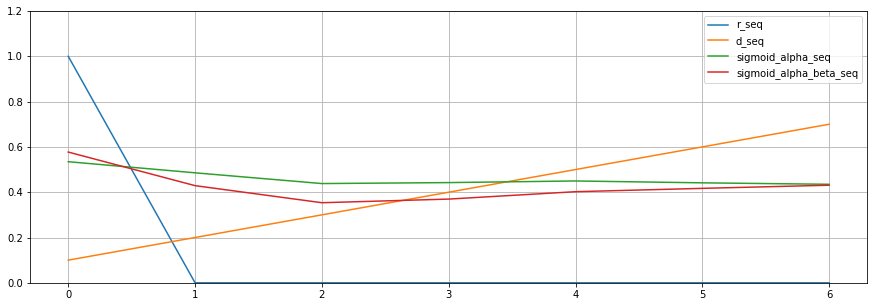

In [9]:
plt.figure(figsize=[15, 5], facecolor="white")
plt.plot(r_seq[0], label="r_seq")
plt.plot((d_seq[0] + 1) / 10, label="d_seq")
plt.plot(sigmoid_alpha_seq, label="sigmoid_alpha_seq")
plt.plot(CQ_seq.T[0], label="sigmoid_alpha_beta_seq")
# plt.plot(sigmoid_alpha_beta_gamma_seq, label="sigmoid_alpha_beta_gamma_seq")
# plt.plot(r_seq_ma, label="r_seq_ma")
plt.grid()
plt.ylim(0, 1.2)
plt.legend()
plt.show()

In [10]:
CQ_seq.T.shape

(181, 7)

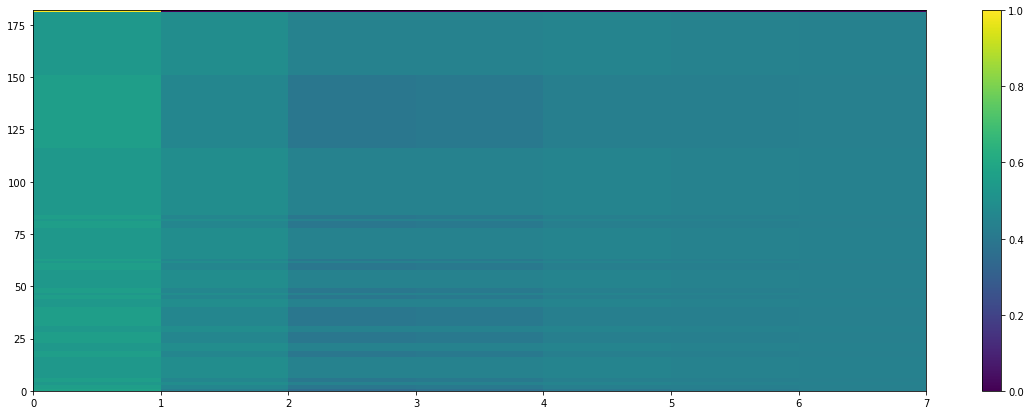

In [11]:
plt.figure(figsize=[20, 7], facecolor="white")
temp = np.concatenate([CQ_seq.T, r_seq], axis=0)
plt.pcolormesh(temp)
plt.colorbar()
plt.show()

# plt.figure(figsize=[15, 0.5], facecolor="white")
# plt.pcolormesh(r_seq)
# plt.show()

In [12]:
CQ_seq[0][np.unique(c2_seq)], CQ_seq[-1][np.unique(c2_seq)], np.unique(c2_seq), c2_seq, d_seq

(array([0.57724077], dtype=float32),
 array([0.4308513], dtype=float32),
 array([0]),
 array([[0, 0, 0, 0, 0, 0, 0]]),
 array([[0, 1, 2, 3, 4, 5, 6]]))

In [13]:
from models.utils import collate_fn

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True,
    collate_fn=collate_fn
)
test_loader = DataLoader(
    test_dataset, batch_size=test_size, shuffle=True,
    collate_fn=collate_fn
)

alphas = []
sigmoid_alphas = []

logits = []
preds = []
tgts = []

for data in train_loader:
    c1_seq, c2_seq, d_seq, r_seq, \
        c1shft_seq, c2shft_seq, dshft_seq, rshft_seq, m_seq = data

    batch_size = c2_seq.shape[0]
    seq_len = c2_seq.shape[1]

    # rshft_seq: [batch_size, seq_len]
    # m_seq: [batch_size, seq_len]

    alpha_seq, h_seq, C1_seq, C2_seq = \
        model(c1_seq, c2_seq, d_seq, r_seq)

    # alpha_seq: [batch_size, seq_len]

    # c1shft_one_hot_seq: [batch_size, seq_len, 1, num_c1]
    # c2shft_one_hot_seq: [batch_size, seq_len, 1, num_c2]
    c1shft_one_hot_seq = one_hot(c1shft_seq, dataset.num_c1).float()
    c1shft_one_hot_seq = torch.reshape(
        c1shft_one_hot_seq,
        shape=[
            -1,
            c1shft_one_hot_seq.shape[1],
            c1shft_one_hot_seq.shape[2]
        ]
    ).unsqueeze(-2)

    c2shft_one_hot_seq = one_hot(c2shft_seq, dataset.num_c2).float()
    c2shft_one_hot_seq = torch.reshape(
        c2shft_one_hot_seq,
        shape=[
            -1,
            c2shft_one_hot_seq.shape[1],
            c2shft_one_hot_seq.shape[2]
        ]
    ).unsqueeze(-2)

    # beta1_shft_seq: [batch_size, seq_len]
    # beta2_shft_seq: [batch_size, seq_len]
    beta1_shft_seq = torch.bmm(
        torch.reshape(
            c1shft_one_hot_seq,
            shape=[
                -1,
                c1shft_one_hot_seq.shape[2],
                c1shft_one_hot_seq.shape[3]
            ]
        ),
        torch.reshape(
            C1_seq, shape=[-1, C1_seq.shape[2], C1_seq.shape[3]]
        )
    )
    beta1_shft_seq = torch.reshape(
        beta1_shft_seq, shape=[batch_size, seq_len]
    )

    beta2_shft_seq = torch.bmm(
        torch.reshape(
            c2shft_one_hot_seq,
            shape=[
                -1,
                c2shft_one_hot_seq.shape[2],
                c2shft_one_hot_seq.shape[3]
            ]
        ),
        torch.reshape(
            C2_seq, shape=[-1, C2_seq.shape[2], C2_seq.shape[3]]
        )
    )
    beta2_shft_seq = torch.reshape(
        beta2_shft_seq, shape=[batch_size, seq_len]
    )

    # gamma_shft_seq: [batch_size, seq_len]
    gamma_shft_seq = model.D(dshft_seq).squeeze()
    
    alphas.append(
        torch.masked_select(
            alpha_seq, m_seq
        )
    )
    sigmoid_alphas.append(
        torch.sigmoid(torch.masked_select(
            alpha_seq, m_seq
        ))
    )
    
    logit = torch.masked_select(
        alpha_seq +
        beta1_shft_seq +
        beta2_shft_seq -
        gamma_shft_seq, m_seq
    )
    pred = torch.sigmoid(logit)
    
    tgt = torch.masked_select(
        r_seq, m_seq
    )
    
    logits.append(logit)
    preds.append(pred)
    tgts.append(tgt)

alphas = torch.cat(alphas, dim=0).detach().cpu().numpy()
sigmoid_alphas = torch.cat(sigmoid_alphas, dim=0).detach().cpu().numpy()

logits = torch.cat(logits, dim=0).detach().cpu().numpy()
preds = torch.cat(preds, dim=0).detach().cpu().numpy()
tgts = torch.cat(tgts, dim=0).detach().cpu().numpy()

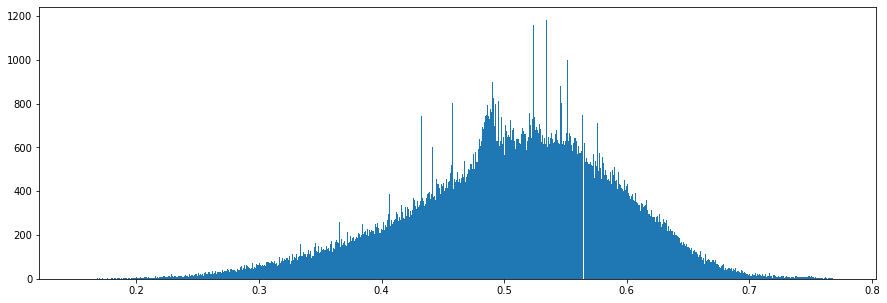

In [14]:
plt.figure(figsize=[15, 5], facecolor="white")
plt.hist(sigmoid_alphas, bins=1000)
plt.show()

In [18]:
num_rep = 1

for c1_seq, c2_seq, d_seq, r_seq in [
    (
        np.array([[c22c1_indices[0]] * 7 * num_rep]),
        np.array([[0] * 7 * num_rep]),
        np.array([[1, 2, 3, 4, 5, 6, 7] * num_rep]) - 1,
        np.array([[1, 1, 1, 1, 1, 1, 1] * num_rep]),
    ),
    (
        np.array([[c22c1_indices[0]] * 7 * num_rep]),
        np.array([[0] * 7 * num_rep]),
        np.array([[1, 2, 3, 4, 5, 6, 7] * num_rep]) - 1,
        np.array([[1, 1, 1, 1, 1, 1, 0] * num_rep]),
    ),
    (
        np.array([[c22c1_indices[0]] * 7 * num_rep]),
        np.array([[0] * 7 * num_rep]),
        np.array([[1, 2, 3, 4, 5, 6, 7] * num_rep]) - 1,
        np.array([[1, 1, 1, 1, 1, 0, 0] * num_rep]),
    ),
    (
        np.array([[c22c1_indices[0]] * 7 * num_rep]),
        np.array([[0] * 7 * num_rep]),
        np.array([[1, 2, 3, 4, 5, 6, 7] * num_rep]) - 1,
        np.array([[1, 1, 1, 1, 0, 0, 0] * num_rep]),
    ),
    (
        np.array([[c22c1_indices[0]] * 7 * num_rep]),
        np.array([[0] * 7 * num_rep]),
        np.array([[1, 2, 3, 4, 5, 6, 7] * num_rep]) - 1,
        np.array([[1, 1, 1, 0, 0, 0, 0] * num_rep]),
    ),
    (
        np.array([[c22c1_indices[0]] * 7 * num_rep]),
        np.array([[0] * 7 * num_rep]),
        np.array([[1, 2, 3, 4, 5, 6, 7] * num_rep]) - 1,
        np.array([[1, 1, 0, 0, 0, 0, 0] * num_rep]),
    ),
    (
        np.array([[c22c1_indices[0]] * 7 * num_rep]),
        np.array([[0] * 7 * num_rep]),
        np.array([[1, 2, 3, 4, 5, 6, 7] * num_rep]) - 1,
        np.array([[1, 0, 0, 0, 0, 0, 0] * num_rep]),
    ),
    (
        np.array([[c22c1_indices[0]] * 7 * num_rep]),
        np.array([[0] * 7 * num_rep]),
        np.array([[1, 2, 3, 4, 5, 6, 7] * num_rep]) - 1,
        np.array([[0, 0, 0, 0, 0, 0, 0] * num_rep]),
    ),
]:
    alpha_seq, h_seq, C1_seq, C2_seq = model(
        LongTensor(c1_seq),
        LongTensor(c2_seq),
        LongTensor(d_seq),
        FloatTensor(r_seq),
    )
    
    sigmoid_alpha_seq = torch.sigmoid(alpha_seq).detach().cpu().numpy()[0]

    CQ_seq = alpha_seq[0].unsqueeze(-1) + C1_seq.squeeze()[:, c22c1_indices] + C2_seq.squeeze()
    CQ_seq = torch.sigmoid(CQ_seq).detach().cpu().numpy()

    C1_seq = C1_seq.squeeze().detach().cpu().numpy()
    C2_seq = C2_seq.squeeze().detach().cpu().numpy()
    
    sigmoid_alpha = sigmoid_alpha_seq[-1]
    sigmoid_alpha_beta = CQ_seq[-1][0]
    
    print(
        "{}, {}, {}, {}".format(
            sigmoid_alpha,
            1 - np.mean(sigmoid_alphas >= sigmoid_alpha),
            sigmoid_alpha_beta,
            1 - np.mean(sigmoid_alphas >= sigmoid_alpha_beta)
        )
    )

0.6363528370857239, 0.9519324213201764, 0.7392662167549133, 0.9987071751777634
0.5975878238677979, 0.8651768399667559, 0.6132383346557617, 0.9066087973650999
0.564624011516571, 0.7476529073167728, 0.5658192038536072, 0.752696683068832
0.5341908931732178, 0.6041625441385345, 0.5329562425613403, 0.5982173089015825
0.4986851215362549, 0.4342088483745147, 0.4968092441558838, 0.4254361085093378
0.46212801337242126, 0.2757102841136455, 0.45894673466682434, 0.2657150772396871
0.4348946511745453, 0.19338724500789328, 0.4308513104915619, 0.1815143639873532
0.36707204580307007, 0.06942996979011384, 0.36288613080978394, 0.06416192850766678


In [19]:
model.D.weight

Parameter containing:
tensor([[-0.7674],
        [-0.5368],
        [-0.2233],
        [ 0.2734],
        [ 0.6828],
        [ 0.8895],
        [ 1.8671]], requires_grad=True)

In [20]:
down = 30
print(70)
print(70 * (1 - down * 1.5 * 1 / 100))
print(35 * (1 - down * 1.5 * 2 / 100) + 35 * (1 - down * 0.75 / 100))
print(30 * (1 - down * 1.5 * 3 / 100) + 40 * (1 - down * 0.75 / 100))

70
38.5
30.625
20.499999999999996


In [21]:
up = 30
print(70)
print(70 * (1 + up * 1.5 * 1 / 100))
print(35 * (1 + up * 1.5 * 2 / 100) + 35 * (1 + up * 0.75 / 100))
print(30 * (1 + up * 1.5 * 3 / 100) + 40 * (1 + up * 0.75 / 100))

70
101.5
109.375
119.5
